In [1]:
import matplotlib.pyplot as plt
import colorcet as cc
import networkx as nx
import pandas as pd
import plotly.graph_objects as go
import sys
from dash import Dash, html
import dash_cytoscape as cytov

sys.path.append("/Users/jlq293/Projects/Study-1-Bibliometrics/src/main_path/")

from MainPathReader import MainPathReader
from MainPathDataAssigner import MainPathDataAssigner
from MainPathPlotterStatic import MainPathPlotterStatic
from MainPathPlotterInteractive import MainPathPlotterInteractive

In [2]:
p = "../data/06-clustered-df/alpha0.3_k10_res0.002.pkl"
df = pd.read_pickle(p)

path_to_main_path = (
    "../data/08-main-paths/20. Key-Route Global Main Path [225-275] of N2 (176).net"
)
mp_reader = MainPathReader(
    path_to_main_path, node_attributes=["eid", "unique_auth_year"]
)
Gmp = mp_reader.get_graph()

DiGraph with 176 nodes and 214 edges


In [3]:
import colorcet as cc
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio


class MainPathPlotterInteractive:
    def __init__(self, G, cluster_col, label_col):
        self.G = G
        self.cluster_col = cluster_col
        self.label_col = label_col

    @staticmethod
    def add_line_breaks(text, char_limit=100):
        words = text.split()
        line = ""
        lines = []
        for word in words:
            if len(line + " " + word) <= char_limit:
                line += " " + word
            else:
                lines.append(line.strip())
                line = word
        if line:
            lines.append(line.strip())
        return "<br>".join(lines)

    def adjust_overlap(self, min_dist=0.1, max_iterations=100):
        """
        Adjusts the positions to reduce overlap.

        :param pos: Dictionary of positions keyed by node.
        :param min_dist: Minimum desired distance between nodes.
        :param max_iterations: Maximum number of iterations to perform adjustments.
        :return: Adjusted positions.
        """
        for _ in range(max_iterations):
            moved = False
            for node1 in self.pos:
                for node2 in self.pos:
                    if node1 != node2:
                        # Calculate the distance between two nodes
                        delta = np.array(self.pos[node1]) - np.array(self.pos[node2])
                        dist = np.sqrt(np.sum(delta**2))
                        # If the nodes are too close, push them apart
                        if dist < min_dist:
                            moved = True
                            displacement = delta / dist * (min_dist - dist) / 2
                            self.pos[node1] += displacement
                            self.pos[node2] -= displacement
            # If no nodes were moved in this iteration, stop the adjustment
            if not moved:
                print(f"Adjustment finished after {_} iterations")
                break
        return self.pos

    def clean_years(self):
        """
        Convert year attribute to integer, if not already
        if multiple years are present, the mean is taken
        """
        # Convert year attribute to integer, if not already
        for node, data in self.G.nodes(data=True):
            if isinstance(data["year"], str):
                mean_year = sum(map(int, data["year"].split(";"))) / len(
                    data["year"].split(";")
                )
                data["year"] = int(mean_year)

        # Sort nodes based on year attribute
        nodes_sorted_by_year = sorted(
            self.G.nodes(data=True), key=lambda x: x[1]["year"], reverse=True
        )

        # Get the range of years
        min_year = min([data["year"] for node, data in nodes_sorted_by_year])
        max_year = max([data["year"] for node, data in nodes_sorted_by_year])

        return min_year, max_year, nodes_sorted_by_year

    def hover_texts(self):
        hover_texts = []
        for node, data in self.G.nodes(data=True):
            wrapped_title = self.add_line_breaks(data["title"])
            hover_title_cluster = (
                f"Cluster: {data[self.cluster_col]}<br>{wrapped_title}"
            )
            hover_title_cluster_cited = f"Cluster: {data[self.cluster_col]}<br>Cited by: {data['citedby_count']}<br>{wrapped_title}"
            hover_texts.append(hover_title_cluster_cited)
        return hover_texts

    def cluster_color_dict(self):
        """
        Creates a dictionary mapping clusters to distinct colors using the colorcet library,
        and returns a list of colors for each node based on its cluster.

        Returns:
            list: A list of color strings in hex format for each node in the graph, based on its cluster.
        """
        clusters = nx.get_node_attributes(self.G, self.cluster_col).values()
        unique_clusters = sorted(set(clusters))

        # Using colorcet to get a colormap with enough distinct colors
        # Adjust the colormap if needed to suit your preferences for color variety and distinctness
        color_list = cc.glasbey_dark[: len(unique_clusters)]

        # Creating a color dictionary mapping each cluster to a color
        color_dict = {
            cluster: color_list[i] for i, cluster in enumerate(unique_clusters)
        }

        # Generating a list of colors for each node based on its cluster
        colors = [color_dict[cluster] for cluster in clusters]
        return colors

    def node_labels(self):
        node_labels = []
        for node, data in self.G.nodes(data=True):
            node_labels.append(data[self.label_col])
        return node_labels

    def edge_positions(self):
        edge_x = []
        edge_y = []
        for edge in self.G.edges():
            x0, y0 = self.pos[edge[0]]
            x1, y1 = self.pos[edge[1]]
            edge_x.append(x0)
            edge_x.append(x1)
            edge_x.append(None)
            edge_y.append(y0)
            edge_y.append(y1)
            edge_y.append(None)
        return edge_x, edge_y

    def get_edge_trace(self):
        edge_x, edge_y = self.edge_positions()
        edge_trace = go.Scatter(
            x=edge_x,
            y=edge_y,
            line=dict(width=0.7, color="#000000"),
            hoverinfo="none",
            mode="lines",
        )
        return edge_trace

    def get_node_trace(self):
        node_x, node_y = zip(*self.pos.values())
        hover_texts = self.hover_texts()
        colors = self.cluster_color_dict()
        node_labels = self.node_labels()
        node_trace = go.Scatter(
            x=node_x,
            y=node_y,
            mode="markers+text",
            hoverinfo="text",
            hovertext=hover_texts,
            text=node_labels,  # Permanent labels for nodes
            textposition="middle center",
            marker=dict(
                showscale=False,
                opacity=0.3,  # Decreased opacity of nodes for the desired transparency
                # colorscale='YlGnBu',
                size=20,
                colorbar=dict(
                    thickness=15,
                    title="Node Connections",
                    xanchor="left",
                    titleside="right",
                ),
                line_width=2,
                color=colors,
            ),
        )
        return node_trace

    def plot_network_on_timeline_interactive(
        self, savingpath=None, return_fig=True, adjust_overlap=True, pos=None
    ):
        # Convert year attribute to integer, if not already
        # min_year, max_year, nodes_sorted_by_year = self.clean_years()

        if not pos:
            self.pos = nx.kamada_kawai_layout(
                self.G,
                weight=None,
                scale=5.0,
                center=None,
                dim=2,
            )  # Use Kamada-Kawai layout for better node positioning
        else:
            self.pos = pos

        if adjust_overlap:
            self.pos = self.adjust_overlap(0.15, 100)

        edge_trace = self.get_edge_trace()

        node_trace = self.get_node_trace()
        width = 1000
        height = 1500
        if len(self.G.nodes) > 190:
            width = 1300
            height = 1500
        # Figure Definition
        fig = go.Figure(
            data=[edge_trace, node_trace],
            layout=go.Layout(
                width=width,  # Example width
                height=height,  # Example height
                showlegend=False,  # Adjust based on your need to show or hide the legend
                hovermode="closest",
                hoverlabel=dict(  # Customizing the hover label's appearance
                    bgcolor="rgba(249, 98, 186, 0.11)",  # Setting the background color to a semi-transparent gray
                    bordercolor="rgba(0, 0, 0, 0.14)",
                    font=dict(color="black"),  # Text color in the hover label
                ),
                margin=dict(b=0, l=0, r=0, t=40),
                xaxis=dict(
                    showline=False,  # Hides the axis line
                    showgrid=False,
                    zeroline=False,
                    showticklabels=False,  # Hide tick labels
                    visible=False,  # Makes the whole axis (including the space for it) invisible
                ),
                yaxis=dict(
                    showline=False,  # Hides the axis line
                    showgrid=False,
                    zeroline=False,
                    showticklabels=False,  # Hide tick labels
                    visible=False,  # Makes the whole axis (including the space for it) invisible
                ),
                dragmode="zoom",
            ),
        )

        plt.tight_layout()
        if savingpath:
            if savingpath.endswith(".html"):  # Use 'savingpath' consistently
                fig.write_html(savingpath)
            elif savingpath.endswith(".png"):
                fig.write_image(savingpath, dpi=300)
        fig.show()
        if return_fig:
            return pio.to_html(fig, full_html=False, include_plotlyjs="cdn")

In [6]:
attr_to_assign = [
    "title",
    "citedby_count",
    "unique_auth_year",
    "doi",
    "year",
    "cluster_alpha0.3_k10_res0.002",
    "centrality_alpha0.3_k10_res0.002",
]

data_assigner = MainPathDataAssigner(Gmp, df, attr_to_assign)
Gmp = data_assigner.process_mp()
print(list(Gmp.nodes(data=True))[0])
clusters = nx.get_node_attributes(Gmp, "cluster_alpha0.3_k10_res0.002").values()
print(f"Nr of clusters: {len(set(clusters))}")

mpp_i = MainPathPlotterInteractive(
    Gmp, cluster_col="cluster_alpha0.3_k10_res0.002", label_col="unique_auth_year"
)
fig = mpp_i.plot_network_on_timeline_interactive(
    return_fig=True, adjust_overlap=False, pos=pos
)

('1', {'label': '"family_2_62"', 'eid': '2-s2.0-0020047901;2-s2.0-0019989539', 'unique_auth_year': 'Boeck_1982;Pedersen_1982', 'title': 'Studies on Acute Toxicity and Drug Levels of Citalopram in the Dog;Citalopram, a selective serotonin reuptake inhibitor: Clinical antidepressive and long-term effect - a phase II study', 'citedby_count': '34;61', 'doi': '10.1111/j.1600-0773.1982.tb00959.x;10.1007/BF00464566', 'year': '1982;1982', 'cluster_alpha0.3_k10_res0.002': '41;12', 'centrality_alpha0.3_k10_res0.002': '0.1013161487101089;0.3020795044519527'})
Nr of clusters: 34


KeyError: '3'

In [9]:
import json
import networkx as nx


def load_cx2_to_networkx(cx2_file_path):
    # Load the CX2 file
    with open(cx2_file_path, "r", encoding="utf-8") as file:
        cx2_data = json.load(file)

    # Create a new NetworkX graph
    G = nx.Graph()

    # Assuming the CX2 structure, iterate through the aspects to find nodes and edges
    for aspect in cx2_data:
        if "nodes" in aspect:
            for node in aspect["nodes"]:
                # Add each node to the graph, you might want to customize the attributes you add
                G.add_node(node["id"], **node)
        elif "edges" in aspect:
            for edge in aspect["edges"]:
                # Add each edge to the graph, again customizing attributes as necessary
                G.add_edge(edge["s"], edge["t"], **edge)
        # Add handling for other aspects like nodeAttributes, edgeAttributes, etc.
        # This will depend on your specific CX2 file structure and what data it contains

    return G


# Usage example
cx2_file_path = "../data/08-main-paths/NEWdata_with_attr.cx2"
G = load_cx2_to_networkx(cx2_file_path)
#
pos = {node: (data["x"], data["y"]) for node, data in G.nodes(data=True)}
len(pos)

185

In [8]:
list(G.nodes(data=True))[0][1]["id"]

523

In [7]:
for n, dat in G.nodes(data=True):
    # pop the first attribute
    # n[1].pop("id")
    print(list(dat.keys()))
    print(n[1].pop(list(n.keys()[0])))
    break

['id', 'x', 'y', 'v']


TypeError: 'int' object is not subscriptable

In [ ]:
pos

{523: (333.39636187971337, -2477.7855211085407),
 521: (-124.85647443559719, -2477.7855211085407),
 519: (333.39636187971337, -2410.7855211085407),
 517: (333.39636187971337, -2343.7855211085407),
 515: (-239.4196835142793, -2477.7855211085407),
 513: (-239.4196835142793, -2410.7855211085407),
 511: (104.26994372240733, -2477.7855211085407),
 509: (218.83315280097304, -2477.7855211085407),
 507: (218.83315280097304, -2410.7855211085407),
 505: (218.83315280097304, -2343.7855211085407),
 503: (104.26994372240733, -2410.7855211085407),
 501: (104.26994372240733, -2343.7855211085407),
 499: (-10.293265356565826, -2477.7855211085407),
 497: (-124.85647443559719, -2343.7855211085407),
 495: (218.83315280097304, -2276.7855211085407),
 493: (-239.4196835142793, -2276.7855211085407),
 491: (333.39636187971337, -2276.7855211085407),
 489: (-239.4196835142793, -2209.7855211085407),
 487: (104.26994372240733, -2276.7855211085407),
 485: (333.39636187971337, -2209.7855211085407),
 483: (-239.41968

185

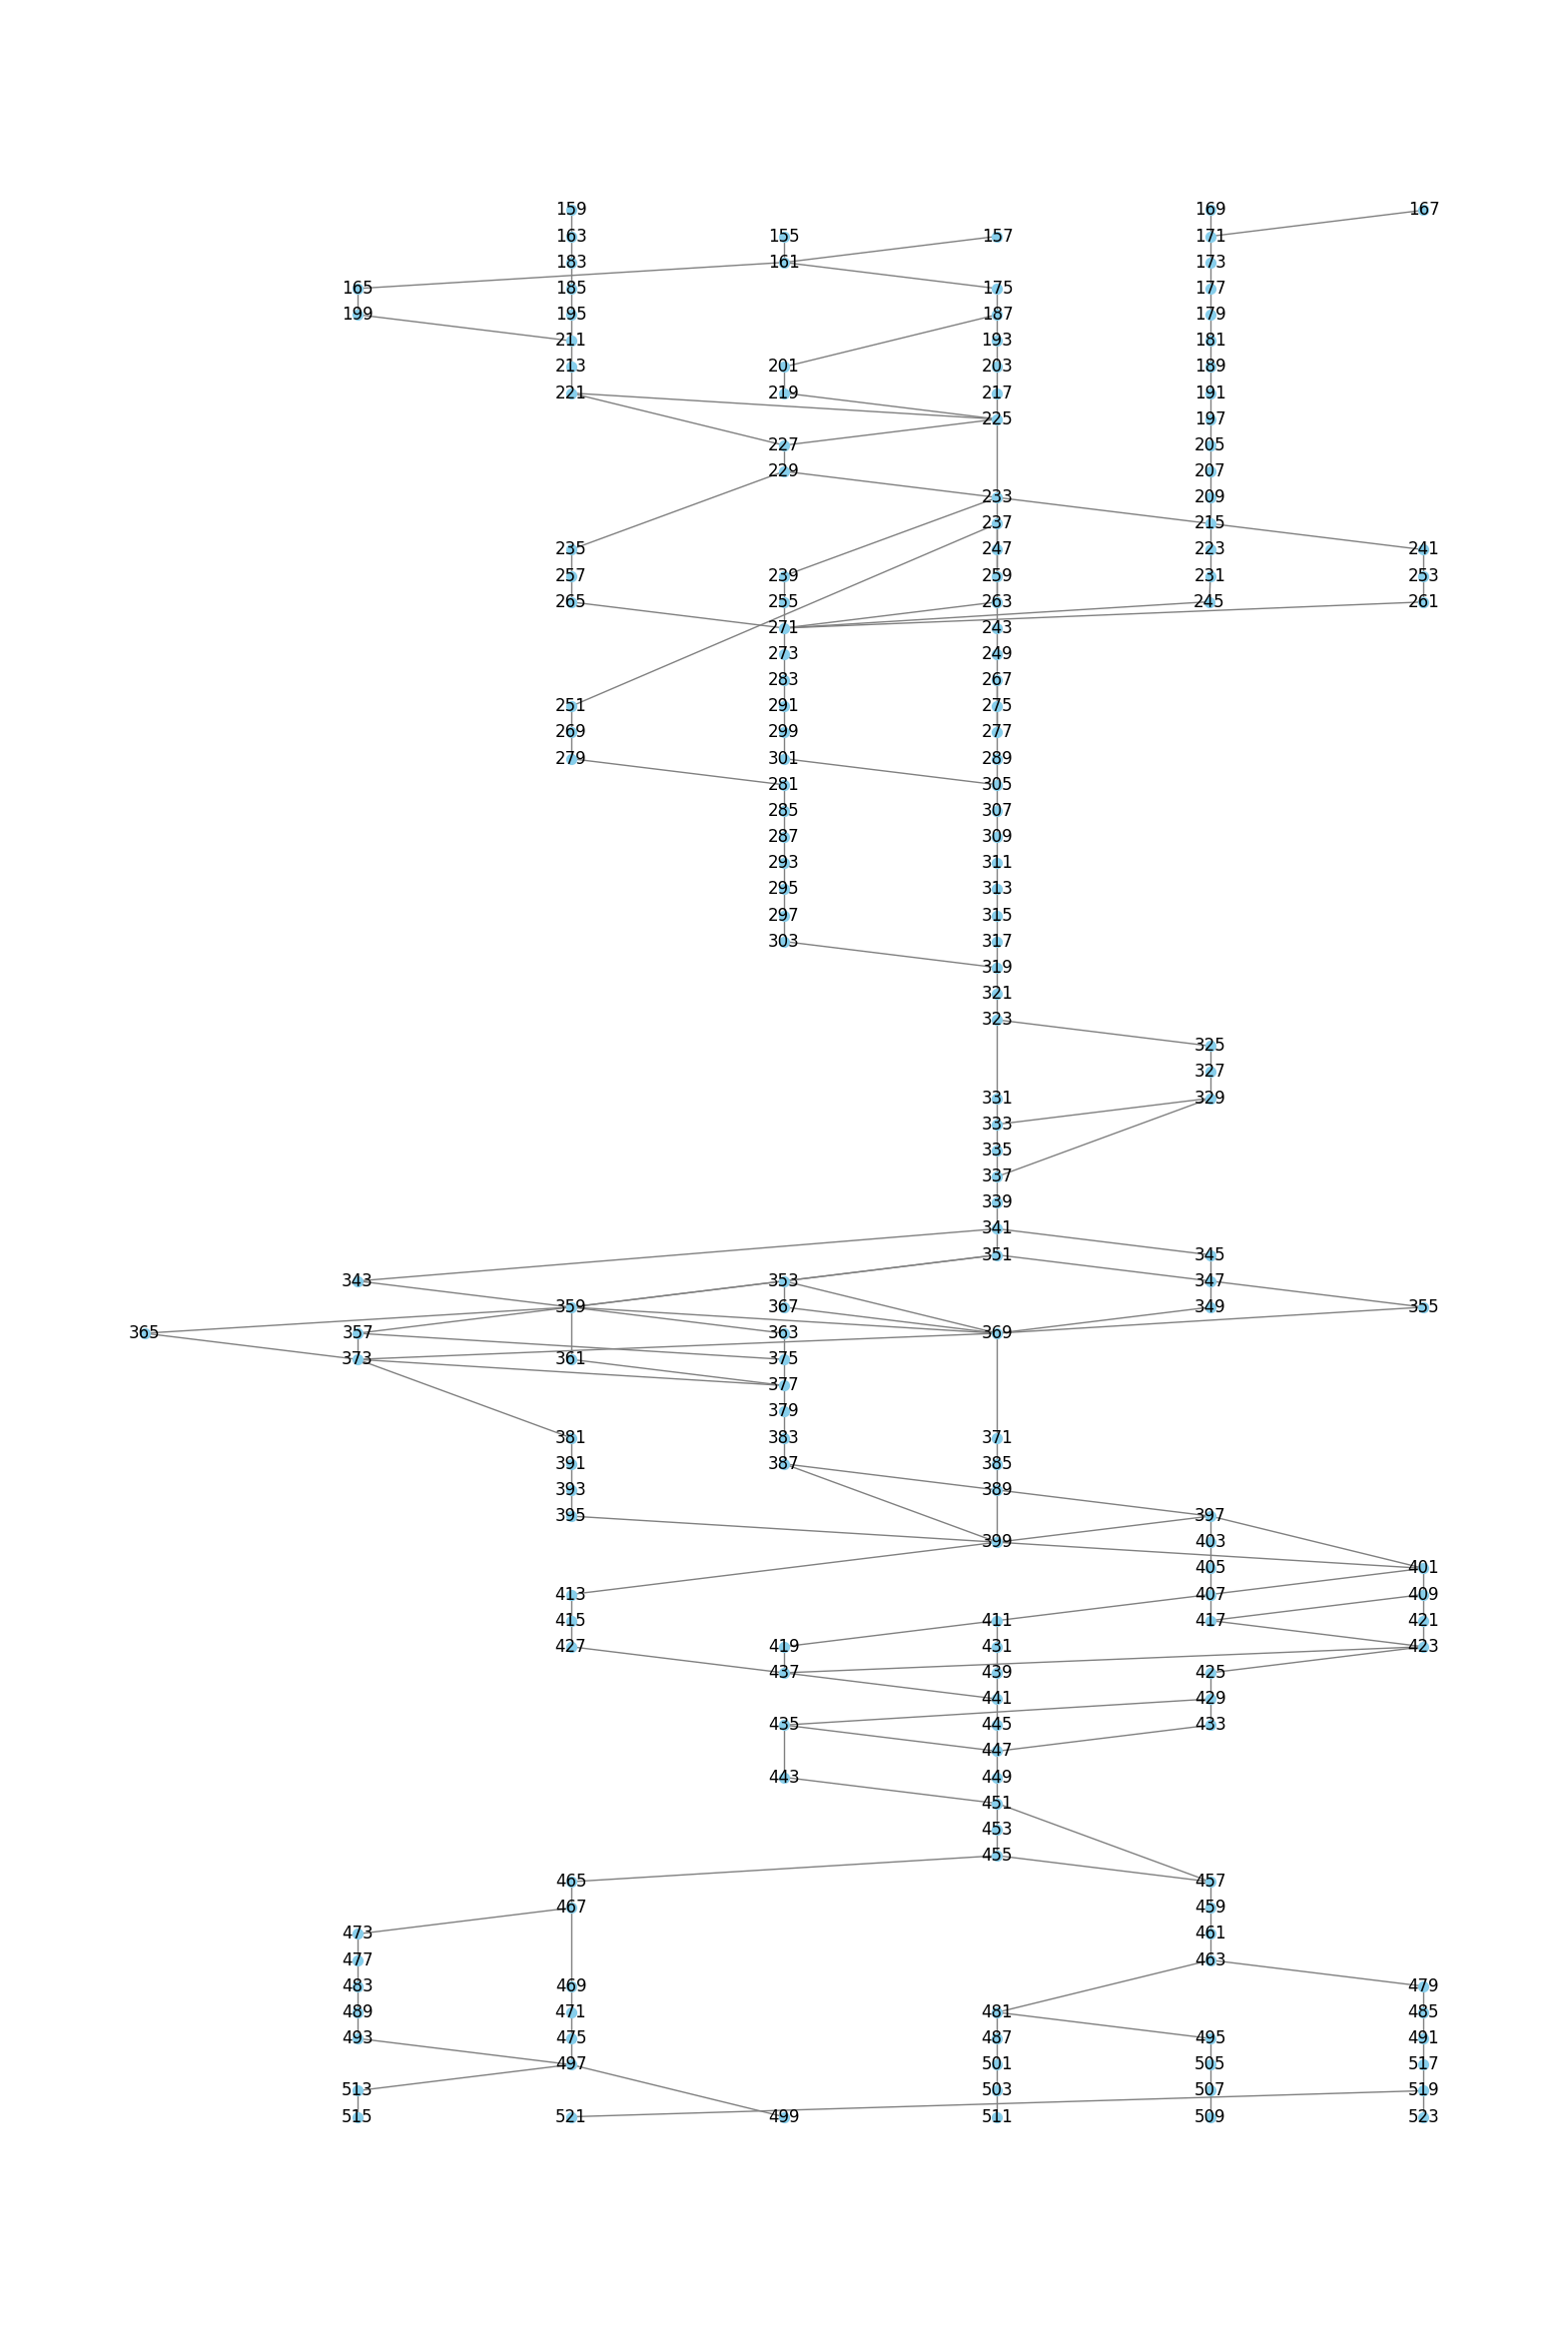

In [10]:
import matplotlib.pyplot as plt
import networkx as nx

# Assuming 'G' is your NetworkX graph and 'pos' contains your node positions

fig, ax = plt.subplots(figsize=(20, 30))
# Draw the graph
nx.draw(G, pos, with_labels=True, node_size=50, node_color="skyblue", edge_color="gray")

# Show plot
plt.show()

In [ ]:
p = "/Users/jlq293/Projects/Study-1-Bibliometrics/output/figures/main-paths/mainpaths.graphml"

G = nx.read_graphml(p)

In [43]:
G.nodes(data=True)[523]["v"]["label"]
families = {}

for n in G.nodes(data=True):
    label = n[1]["v"]["label"]
    if "family" in label:
        print(label)
        families[label.replace('"', "")] = n[1]["v"]

"family_2_62"
"family_33_36_37_40"
"family_37080_782_879"
"family_1437_1457"
"family_13559_15577_16706_16707_17531_17667_18306_19159_19885_19975_21844_23241_39471"
"family_14730_14817_15608_16134_17818_20318_20575_21319_21359_21456_23382_23575_24525_25803_26336_27789"
"family_30108_30257"


In [54]:
families[
    "family_13559_15577_16706_16707_17531_17667_18306_19159_19885_19975_21844_23241_39471"
]

eids = families[
    "family_13559_15577_16706_16707_17531_17667_18306_19159_19885_19975_21844_23241_39471"
]["eid"].split(";")

random
preset
circle
concentric
grid
breadthfirst
bilkent
fcode
cola
euler
spread
dagre
klay


In [118]:
df = pd.read_csv(
    "/Users/jlq293/Projects/Study-1-Bibliometrics/data/01-raw/scopus/articles/final_scopus_results.csv"
)
df.columns

Index(['@_fa', 'link', 'prism:url', 'dc:identifier', 'eid', 'dc:title',
       'dc:creator', 'prism:publicationName', 'prism:issn', 'prism:volume',
       'prism:issueIdentifier', 'prism:pageRange', 'prism:coverDate',
       'prism:coverDisplayDate', 'pii', 'dc:description', 'citedby-count',
       'affiliation', 'prism:aggregationType', 'subtype', 'subtypeDescription',
       'author-count', 'author', 'authkeywords', 'source-id', 'fund-no',
       'openaccess', 'openaccessFlag', 'prism:doi', 'pubmed-id', 'prism:eIssn',
       'freetoread', 'freetoreadLabel', 'fund-acr', 'fund-sponsor',
       'prism:isbn', 'article-number'],
      dtype='object')

In [114]:
grouped_df = df.groupby("prism:issn").filter(lambda x: len(x) > 1)

In [125]:
df[df["dc:title"].str.contains("Citalopram versus other anti-depressive")]

,@_fa,link,prism:url,dc:identifier,eid,dc:title,dc:creator,prism:publicationName,prism:issn,prism:volume,...,openaccessFlag,prism:doi,pubmed-id,prism:eIssn,freetoread,freetoreadLabel,fund-acr,fund-sponsor,prism:isbn,article-number
16479,True,"[{'@_fa': 'true', '@ref': 'self', '@href': 'ht...",https://api.elsevier.com/content/abstract/scop...,SCOPUS_ID:44949118585,2-s2.0-44949118585,Citalopram versus other anti-depressive agents...,Imperadore G.,Cochrane Database of Systematic Reviews,1469493X,NaN,...,False,10.1002/14651858.CD006534,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CD006534
23925,True,"[{'@_fa': 'true', '@ref': 'self', '@href': 'ht...",https://api.elsevier.com/content/abstract/scop...,SCOPUS_ID:84866456643,2-s2.0-84866456643,Citalopram versus other anti-depressive agents...,Cipriani A.,Cochrane database of systematic reviews (Online),NaN,7,...,False,NaN,22786497.0,1469493X,NaN,NaN,NaN,NaN,NaN,NaN


In [102]:
dfs = df[
    [
        "year",
        "doi",
        "eid",
        "title",
        "citedby_count",
        "unique_auth_year",
        "filtered_reference_eids",
        "cluster_alpha0.3_k10_res0.002",
    ]
]

In [ ]:
22786497
22786497

In [103]:
df_fam = dfs[dfs["eid"].isin(eids)]

label_eid_dict = dict(zip(df_fam["eid"], df_fam["unique_auth_year"]))

df_fam

,year,doi,eid,title,citedby_count,unique_auth_year,filtered_reference_eids,cluster_alpha0.3_k10_res0.002
13559,2007,10.1002/14651858.CD004851.pub2,2-s2.0-36749030372,Selective serotonin reuptake inhibitors (SSRIs...,165,Hetrick_2007,"[2-s2.0-84891671428, 2-s2.0-0025654358, 2-s2.0...",6
15577,2008,10.2217/14622416.9.11.1725,2-s2.0-61549121732,Pharmacogenetics of selective serotonin reupta...,20,Kronenberg_2008,"[2-s2.0-43349103453, 2-s2.0-0038354618, 2-s2.0...",6
16706,2009,10.1002/14651858.CD006117.pub2,2-s2.0-67549083594,Sertraline versus other antidepressive agents ...,63,Cipriani_2009_3,"[2-s2.0-0029295570, 2-s2.0-0037077490, 2-s2.0-...",83
16707,2009,10.1002/14651858.CD006532.pub2,2-s2.0-67649634725,Escitalopram versus other antidepressive agent...,109,Cipriani_2009_4,"[2-s2.0-2642585582, 2-s2.0-0038441914, 2-s2.0-...",19
17531,2010,10.1002/14651858.CD006114.pub2,2-s2.0-77951215975,Fluvoxamine versus other anti-depressive agent...,30,Omori_2010,"[2-s2.0-0027942559, 2-s2.0-0031035532, 2-s2.0-...",26
17667,2010,10.1542/peds.2009-2317,2-s2.0-77951824710,Comparative safety of antidepressant agents fo...,84,Schneeweiss_2010_2,"[2-s2.0-33845284249, 2-s2.0-33644746311, 2-s2....",27
18306,2011,10.4088/JCP.08m04927blu,2-s2.0-81755162078,Meta-analysis of efficacy and treatment-emerge...,34,Carpenter_2011,"[2-s2.0-33646700743, 2-s2.0-13244282046, 2-s2....",27
19159,2011,10.1038/jp.2010.211,2-s2.0-80052386238,Long-term outcome following selective serotoni...,63,Klinger_2011,"[2-s2.0-49949087415, 2-s2.0-22344455377, 2-s2....",3
19885,2012,10.1136/archdischild-2011-214239,2-s2.0-85027952730,"Maternal use of SSRIs, SNRIs and NaSSAs: Pract...",75,Sie_2012,"[2-s2.0-66149160394, 2-s2.0-70349432273, 2-s2....",3
19975,2012,10.1517/14656566.2012.652085,2-s2.0-84856272650,Paroxetine for the treatment of depression: A ...,20,Gibiino_2012,"[2-s2.0-37349096599, 2-s2.0-0141783736, 2-s2.0...",32


In [89]:
G.nodes(data=True)

NodeDataView({'2-s2.0-36749030372': {}, '2-s2.0-61549121732': {}, '2-s2.0-67549083594': {}, '2-s2.0-67649634725': {}, '2-s2.0-77951215975': {}, '2-s2.0-77951824710': {}, '2-s2.0-81755162078': {}, '2-s2.0-80052386238': {}, '2-s2.0-85027952730': {}, '2-s2.0-84856272650': {}, '2-s2.0-84891671428': {}, '2-s2.0-84925966016': {}, '2-s2.0-44949118585': {}, 'Hetrick_2007': {}, 'Magni_2013': {}, 'Kronenberg_2008': {}, 'Cipriani_2009_3': {}, 'Imperadore_2007': {}, 'Cipriani_2009_4': {}, 'Omori_2010': {}, 'Purgato_2014': {}, 'Schneeweiss_2010_2': {}, 'Carpenter_2011': {}, 'Klinger_2011': {}, 'Sie_2012': {}, 'Gibiino_2012': {}})

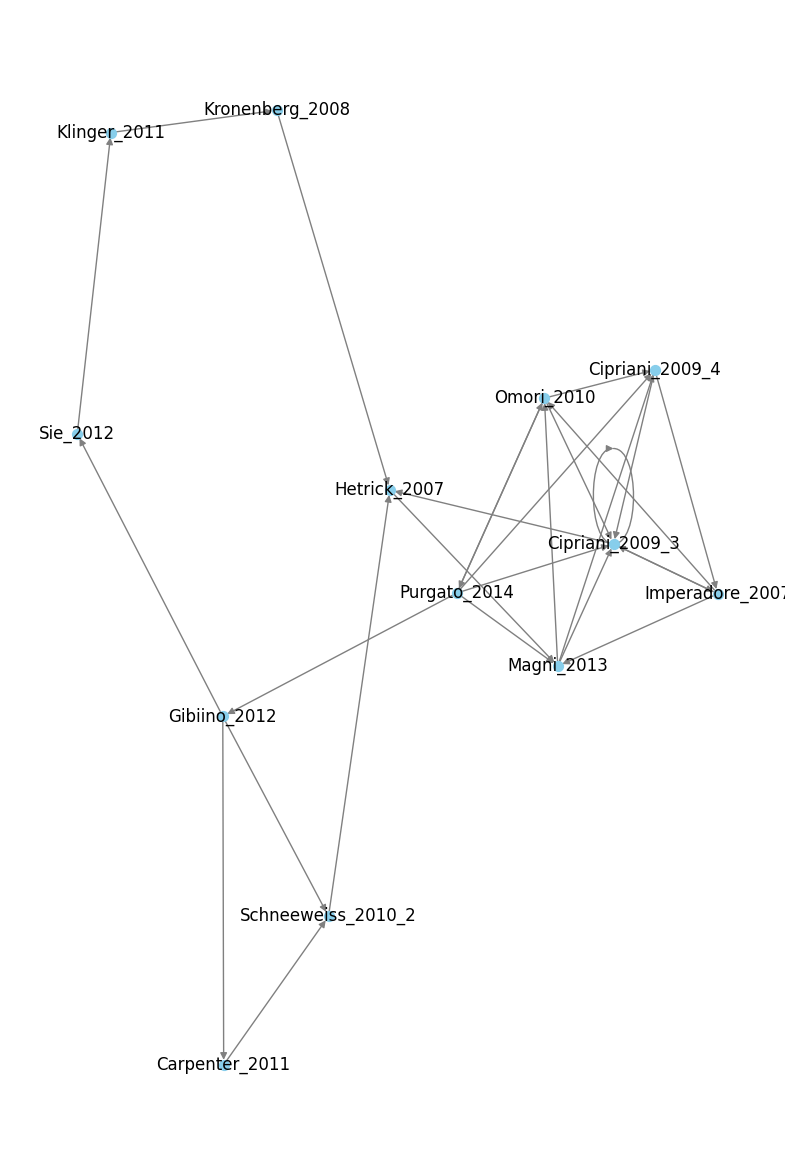

In [91]:
label_eid_dict = dict(zip(df_fam["eid"], df_fam["unique_auth_year"]))


nodes = df_fam["unique_auth_year"].values
edges = []

for i, row in df_fam.iterrows():
    for ref in row["filtered_reference_eids"]:
        if ref in label_eid_dict.keys():
            edges.append((row["unique_auth_year"], label_eid_dict[ref]))

G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# kamada
pos = nx.kamada_kawai_layout(G, weight=None, scale=5.0, center=None, dim=2)

# draw
fig, ax = plt.subplots(figsize=(10, 15))
nx.draw(G, pos, with_labels=True, node_size=50, node_color="skyblue", edge_color="gray")
plt.show()

In [96]:
edges

for edge in edges:
    year1 = pd.to_numeric(edge[0].split("_")[1])
    year2 = pd.to_numeric(edge[1].split("_")[1])

    if year2 > year1:
        print("error")
        print(edge)

error
('Hetrick_2007', 'Magni_2013')
error
('Omori_2010', 'Purgato_2014')
error
('Imperadore_2007', 'Omori_2010')
error
('Imperadore_2007', 'Magni_2013')
error
('Imperadore_2007', 'Cipriani_2009_3')


In [ ]:
cyelements = [
    {
        "data": {"id": str(n[1]["eid"]), "label": str(n[1]["unique_auth_year"])},
        "position": {"x": 75, "y": 75},
    }
    for n in Gmp.nodes(data=True)
]

cyelements

stylesheet = [
    # Style for the nodes
    {
        "selector": "node",
        "style": {
            "background-color": "#7FDBFF",
            "label": "data(label)",
            "color": "#000",
        },
    },
    # Style for the edges
    {
        "selector": "edge",
        "style": {
            "line-color": "#0074D9",
            "target-arrow-color": "#0074D9",
            "target-arrow-shape": "triangle",
            "curve-style": "bezier",
        },
    },
]

app = Dash(__name__)

app.layout = html.Div(
    [
        cyto.Cytoscape(
            id="cytoscape-example",
            layout={"name": "circle"},  # Assuming you have included Cola layout
            style={"width": "100%", "height": "400px"},
            elements=cyelements,  # Your defined elements
            stylesheet=stylesheet,  # Your defined stylesheet for a light theme
        )
    ]
)

if __name__ == "__main__":
    app.run(debug=True)

In [ ]:
from dash import Dash, html
import dash_cytoscape as cyto


app = Dash(__name__)

app.layout = html.Div(
    [
        cyto.Cytoscape(
            id="cytoscape-mpgraph",
            layout={"name": "bilkent"},
            style={"width": "100%", "height": "400px"},
            elements=cyelements,
        )
    ]
)

if __name__ == "__main__":
    app.run(debug=True)

NameError: name 'cyelements' is not defined